<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 9.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 9.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [1120]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, input_shape=(100,)))
    model.add(layers.Reshape((7,7,256)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU'))
    model.add(layers.Conv2D(1,3,1,padding='same',activation='sigmoid'))
    model.summary()
    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(256,5,2,padding='same',activation='LeakyReLU')(input_img)

    x = layers.Dropout(.6)(x)

    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)
    
    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)
    
    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.6)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model



In [1121]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [1122]:
generator = make_generator_model()
discriminatorW = make_discriminator_model()
discriminatorU = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.000004)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_227 (Dense)           (None, 12544)             1266944   
                                                                 
 reshape_31 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_65 (Bat  (None, 7, 7, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 14, 14, 128)      295040    
 Transpose)                                                      
                                                                 
 batch_normalization_66 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                                                     

In [1123]:
BATCH_SIZE = 64

#@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [1124]:
NOISE_DIM = 100
GP_WEIGHT = 100


#@tf.function
def train_step(images):
    

    for i in range(3):
      with tf.GradientTape() as disc_tapeU:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator(noise, training=True)

        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)




      gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))
      if i == 0:
        weights = discriminatorU.get_weights()


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator(noise, training=True)

        real_outputW = discriminatorW(images, training=True)
        fake_outputW = discriminatorW(generated_images, training=True)
        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)
        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)


        gen_lossU = cross_entropy(tf.ones_like(fake_outputU), fake_outputU)
        gen_lossW = generator_lossW(fake_outputW)
        gen_loss = gen_lossW+gen_lossU

        gp = gradient_penalty(images, generated_images)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_lossU',gen_lossU,'gen_lossW',gen_lossW)

In [1125]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 100
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_lossW 1.43252265 disc_lossU 3.17056887e-08 gen_lossU 2.47580232e-08 gen_lossW 1.90192819
disc_lossW 1.795892 disc_lossU 4.33302318e-08 gen_lossU 6.73314426e-09 gen_lossW 1.24813
disc_lossW 1.28736389 disc_lossU 1.4187675e-08 gen_lossU 4.05521268e-06 gen_lossW 2.89440727
disc_lossW 1.36363518 disc_lossU 1.7224886e-09 gen_lossU 2.60429175e-07 gen_lossW 1.62409401
disc_lossW 1.43194759 disc_lossU 3.13397368e-06 gen_lossU 3.29205214e-08 gen_lossW 0.81630373
disc_lossW -0.0373721719 disc_lossU 6.29462704e-08 gen_lossU 6.39937667e-08 gen_lossW 1.29184413
disc_lossW 0.589345634 disc_lossU 3.34153079e-08 gen_lossU 1.70613191e-07 gen_lossW 2.60844755
disc_lossW -1.92145216 disc_lossU 3.13526499e-07 gen_lossU 8.72514949e-10 gen_lossW 4.72038555
disc_lossW 2.1538353 disc_lossU 3.65584825e-08 gen_lossU 6.46561915e-08 gen_lossW 1.43177462
disc_lossW 2.2459445 disc_lossU 1.05306782e-07 gen_lossU 4.27239826e-08 gen_lossW 1.05999362
disc_lossW 1.1764667 disc_lossU 6.30043786e-08 gen_lossU 1.94345

1/1 [==============================] - 0s 21ms/step


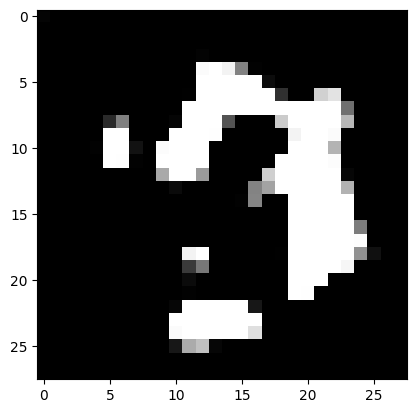

In [1201]:
noise = tf.random.normal(shape=(1,100))
test = generator.predict(noise)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [987]:
print(np.min(x_train2))

0.0
